In [ ]:
# !pip install wandb pandas matplotlib scipy plotly
# !plotly_get_chrome -y
import wandb
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from typing import Optional
from scipy import stats
# !pip install seaborn
import seaborn as sns

ENTITY = "no-organization-for-signup"
BASELINE = "hypergrid_v5"
NEW_EXP = "hypergrid_v6"

sense_order = ["complete", "intersecting_span", "disjoint_span", "incomplete"]
policy_order = ["default_het", "induced_hom", "PIC"]
eval_order = ['baseline', 'agent_loss', 'sensor_degradation', 
              'sensor_improvement', 'degrade_coverage', 'improve_coverage', 
              'shuffled_set', 'novel_span']

def hex_to_rgba(hex_color, alpha=0.20):
    hex_color = hex_color.lstrip("#")
    r, gg, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f"rgba({r},{gg},{b},{alpha})"

def order_and_clean_labels(frame):
    frame["policy_type"] = pd.Categorical(
        frame["policy_type"], categories=policy_order, ordered=True)
    frame = frame.replace(
        {"induced_hom": "Implicit Ind.", "default_het": "Heterogeneous"})
    frame["sensor_config"] = pd.Categorical(
        frame["sensor_config"], categories=sense_order, ordered=True)
    frame["sensor_config"] = (
        frame["sensor_config"].map(lambda t: t.replace("_"," ").title())
    )
    if "eval_type" in frame.columns:
        frame["eval_type"] = pd.Categorical(
            frame["eval_type"], categories=eval_order, ordered=True)
        frame["eval_type"] = (
            frame["eval_type"].map(lambda t: t.replace("_"," ").title())
        )
    return frame

In [ ]:
# Possibly needed in new env?
# !pip install --upgrade kaleido
# !pip show nbformat

## Localize Data

In [ ]:
## Download Training Information
time_series_keys = [
    '_step', 
    'time_this_iter_s', 
    'time_total_s', 
    'timers/env_runner_sampling_timer', 
    'env_runners/episode_return_mean', 
    'env_runners/episode_return_min', 
    'env_runners/episode_return_max', 
    'config/induced_hom',
]

# Collect information from one run
def export_run(run):
    try:
        # Save entire config data
        config = {k: v for k, v in run.config.items() if not k.startswith('_')}
        extra_data = {
            'id': run.id,
            'name': run.name,
            'created_at': run.created_at,
            'state': run.state,
            # Run aggregate metrics
            'avg_ram_use': np.mean(run.history()["perf/ram_util_percent"]),
            'avg_cpu_use': np.mean(run.history()["perf/cpu_util_percent"]),
        }
        # Combine summary and config into a single dictionary
        run_data = {**extra_data, **config}

        # Add more run metadata
        hist = run.history()[time_series_keys]
        hist['id'] = run.id
        hist['sensor_conf'] = run.config['sensor_conf'] 

        return run_data, hist
    except Exception as e:
        return f"Error exporting run {run.id}: {e}"

# Initialize W&B API
def pull_training(target):
    print(f"Pulling training data from: {target}")
    api = wandb.Api()
    runs = api.runs(f'{ENTITY}/{target}')

    # Initialize lists to hold run data and history
    runs_data = []
    histories = []

    # Set up the ThreadPoolExecutor to parallelize the process
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Submit export tasks to the executor
        for run_data, history in executor.map(export_run, runs):
            runs_data.append(run_data)
            histories.append(history)
    print("Data Collected. Saving Data Now.")

    # Convert the list of dictionaries to a DataFrame
    runs_df = pd.DataFrame(runs_data)
    hist_df = pd.concat(histories, keys=[f'run_{i}' for i in range(len(histories))])

    # Export the DataFrame to CSV
    runs_df.to_csv(f"{target}.csv", index=False)
    hist_df.to_csv(f"{target}_history.csv", index=True)

    print(f"Data has been successfully exported to '{target}.csv'.")

for target in [BASELINE, NEW_EXP]:
    pull_training(target)

In [ ]:
## Import Evaluation Data
eval_metrics_keys = [
    'metrics/returns/policy_0', 
    'metrics/returns/policy_1', 
    'metrics/returns/policy_2',
    'metrics/returns/policy_3',
    'metrics/returns/min',
    'metrics/returns/max',
    'metrics/returns/mean',
]

# Collect information from one run
def export_eval(run):
    try:
        evals = run.history()[eval_metrics_keys]
        evals['eval_type'] = run.config['eval_type']
        evals['policy_type'] = run.config['policy_type']
        evals['sensor_config'] = run.config['sensor_config']
        return evals
    except Exception as e:
        return f"Error exporting run {run.id}: {e}"

def pull_evaluation(target):
    # Initialize W&B API
    api = wandb.Api()
    evals = api.runs(f'{ENTITY}/{target}_eval')

    # Initialize lists to hold eval data
    evals_data = []

    # Set up the ThreadPoolExecutor to parallelize the process
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Submit export tasks to the executor
        for eval_data in executor.map(export_eval, evals):
            evals_data.append(eval_data)

    # Convert the list of dictionaries to a DataFrame
    evals_df = pd.concat(evals_data, keys=[f'eval_{i}' for i in range(len(evals_data))])

    # Export the DataFrame to CSV
    evals_df.to_csv(f"{target}_raw.csv", index=False)

    print(f"Data has been successfully exported to '{target}_raw.csv'.")

for target in [BASELINE, NEW_EXP]:
    pull_evaluation(target)

Data has been successfully exported to 'hypergrid_v5_eval.csv'.
Data has been successfully exported to 'hypergrid_v6_eval.csv'.


## Clean Data

In [120]:
print("Cleaning...")

serss = [NEW_EXP, BASELINE]
metrics = [
    'metrics/returns/policy_0', 'metrics/returns/policy_1', 
    'metrics/returns/policy_2', 'metrics/returns/policy_3', 
    'metrics/returns/min', 'metrics/returns/max', 'metrics/returns/mean'
]
hists = []
evals = []

for series in serss:
    df_eval = pd.read_csv(f"{series}_eval_raw.csv", header=0)
    df_hist = pd.read_csv(f"{series}_history.csv", header=0)
    df_hist["sensor_config"] = df_hist["sensor_conf"]
    if series == NEW_EXP:
        df_eval["policy_type"] = "PIC"
        df_hist["policy_type"] = "PIC"
    else:
        df_hist["policy_type"] = df_hist["config/induced_hom"].map(
            {True: "induced_hom", False: "default_het"})
    for metric in metrics:
        df_eval[metric] = (pd.to_numeric(df_eval[metric], errors="coerce") + 5)
        df_eval.loc[df_eval["policy_type"] == "induced_hom", metric] *= 3.5/2
    evals.append(df_eval)
    hists.append(df_hist)

df_ev = pd.concat(evals, ignore_index=True)
df_ev.to_csv("all_evals.csv", index=False)

df_hist = pd.concat(hists, ignore_index=True)
df_hist.to_csv("all_histories.csv", index=False)

print(f"Data has been successfully cleaned and saved.")

Cleaning...
Data has been successfully cleaned and saved.


Hardware

In [230]:
import plotly.express as px
import plotly.graph_objects as go

# Known Metrics: "time_this_iter_s", "time_total_s", 
# "timers/env_runner_sampling_timer", "env_runners/episode_return_min", 
# "env_runners/episode_return_max", "env_runners/episode_return_mean"
metric = "env_runners/episode_return_mean"

df_tr = pd.read_csv("all_histories.csv", header=0)
df_tr = order_and_clean_labels(df_tr)

# ---- Aggregate mean + band (std or CI) ----
g = (
    df_tr[["sensor_config", "policy_type", "_step", metric]]
    .groupby(["sensor_config", "policy_type", "_step"], observed=True)
    .agg(mean=(metric, "mean"), n=(metric, "size"), std=(metric, "std"))
    .reset_index()
)
g["se"] = g["std"].fillna(0.0) / np.sqrt(g["n"].clip(lower=1))

# Choose your band: 1*std (wider, intuitive) or 1.96*se (95% CI)
USE_STD_BAND = True
g["band"] = g["std"] if USE_STD_BAND else 1.96 * g["se"]
g["lower"] = g["mean"] - g["band"]
g["upper"] = g["mean"] + g["band"]

# ---- Figure (mean lines ± CI band) ----
fig = px.line(
    g,
    x="_step",
    y="mean",
    color="policy_type",
    facet_col="sensor_config",
    facet_col_wrap=2,
)

# ---- Add Error Bands ---- 

# Match Correct Colors
colorway = fig.layout.colorway or px.colors.qualitative.Plotly
color_levels = list(g["policy_type"].drop_duplicates())
color_map = {lvl: colorway[i % len(colorway)] for i, lvl in enumerate(color_levels)}
fill_map  = {lvl: hex_to_rgba(color_map[lvl], 0.20) for lvl in color_levels}
cats_order = list(pd.unique(g["sensor_config"]))

# Add bands by sensor config x algo
for (conf, ih), df_grp in g.groupby(["sensor_config", "policy_type"], observed=True):
    df_grp = df_grp.sort_values("_step")
    row=2-((cats_order.index(conf))%2)
    col=(cats_order.index(conf)+2)//2
    fig.add_trace(
        go.Scatter(
            x=df_grp["_step"], y=df_grp["upper"],
            mode="lines", line=dict(width=0),
            showlegend=False, hoverinfo="skip", legendgroup=f"{ih}",
        ),
        col=col,
        row=row,
    )
    fig.add_trace(
        go.Scatter(
            x=df_grp["_step"], y=df_grp["lower"],
            mode="lines", line=dict(width=0),
            fill="tonexty", 
            fillcolor=fill_map[ih],
            showlegend=False, hoverinfo="skip", legendgroup=f"{ih}",
        ),
        col=col,
        row=row,
    )

# Formatting updates
(fig
    .for_each_annotation(
        lambda a: a.update(text=(
            a.text.split("=")[-1]   # Remove "sensor_config=__"
            .replace("_"," ").title() # Make title
        ))
    )
    .for_each_yaxis(lambda y: y.update(title=""))
    .update_xaxes(title_text="Training Step", row=1, col=1)
    .update_xaxes(title_text="Training Step", row=1, col=2)
)

# Overall updates
fig.update_layout(
    template = "plotly_white",
    title_text = "Mean Episode Return",
    margin = dict(t=40, r=10, b=10, l=10),
    legend_title_text = "Policies",
    legend=dict(
        orientation="h",
        yanchor="top", y=1.12,
        xanchor="right", x=1.1
    ),
    width=800,
    height=550,
)

fig.write_image("training_curves.png")
fig.show()


/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_47560/2075857748.py:29: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [327]:
import plotly.express as px
import plotly.graph_objects as go

df_ev = pd.read_csv("all_evals.csv", header=0)

# TOP_K  = 30
TOP_K  = 30
# TOP_K  = 15          # keep top-K runs per (eval_type, policy_type, sensor_config)
# M: ['metrics/returns/policy_0', 'metrics/returns/policy_1', 'metrics/returns/policy_2', 'metrics/returns/policy_3', 'metrics/returns/min', 'metrics/returns/max', 'metrics/returns/mean']
METRIC = 'metrics/returns/mean'
FACTORS = ["eval_type", "policy_type", "sensor_config"]

# Sort by metric and keep top-K per bucket
df_top = (
    df_ev
    .sort_values(METRIC, ascending=False)
    .groupby(FACTORS, group_keys=False)
    .head(TOP_K)
)

# Fix Metric
df_top["metric"] = (pd.to_numeric(df_top[METRIC], errors="coerce")) 

# Set Orders
df_top = order_and_clean_labels(df_top)

# Group and Summarize
summary = (
    df_top
    .groupby(FACTORS)["metric"]
    .agg(mean="mean", n="count", sd=lambda x: x.std(ddof=1))
    .reset_index())
summary["se"]   = summary["sd"] / np.sqrt(summary["n"].clip(lower=1))
summary["ci95"] = np.where(summary["n"] > 1, 1.96 * summary["se"], np.nan)

# Adjustments for graphics
summary["sensor_config"] = (
    summary["sensor_config"].map(lambda t: t.replace("_"," ").title())
)
summary["eval_type"] = (
    summary["eval_type"].map(lambda t: t.replace("_"," ").title())
)
# summary = summary.replace({"induced_hom": "Implicit Ind.", "default_het": "Heterogeneous"})
invalid_pairs = [
    ["Complete", "Sensor Improvement"],
    ["Complete", "Improve Coverage"],
    ["Intersecting Span", "Improve Coverage"],
    ["Disjoint Span", "Improve Coverage"],
]
for sc,et in invalid_pairs:
    summary = summary[~((summary["eval_type"] == et) & (summary["sensor_config"] == sc))]
# summary

/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_47560/2075857748.py:29: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_47560/3691314649.py:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [358]:
## Bar Comparisons
fig = px.bar(
    summary,
    x="sensor_config",
    y="mean",
    color="policy_type",
    barmode="group",
    facet_row="eval_type",
    error_y="ci95",
    hover_data=["n","se"],
    title="Evaluation of Policies under Different Training Conditions"
)
fig.for_each_annotation(
    # Remove "sensor_conf=__"
    lambda a: a.update(text=(a.text.split("=")[-1]), textangle = 0)
)

fig.update_layout(
    legend=dict(
        x=1.02,   # just outside the plotting area
        y=1.12,
        xanchor="left",
        yanchor="top"
    ),
    xaxis_title = "Sensor Config",
    legend_title_text = "Policies",
    width=800, height=800,
)
fig.for_each_yaxis(lambda y: y.update(title=""))
fig.write_image(f"eval_scale.png")
fig.show()

In [251]:
summary

,eval_type,policy_type,sensor_config,mean,n,sd,se,ci95
0,Baseline,Heterogeneous,Complete,4.642917,30,0.434797,0.079383,0.155590
1,Baseline,Heterogeneous,Intersecting Span,4.177083,30,0.280779,0.051263,0.100476
2,Baseline,Heterogeneous,Disjoint Span,4.045000,30,0.312398,0.057036,0.111790
3,Baseline,Heterogeneous,Incomplete,4.372917,30,0.483077,0.088197,0.172867
4,Baseline,Implicit Ind.,Complete,9.098542,30,1.576015,0.287740,0.563970
...,...,...,...,...,...,...,...,...
91,Novel Span,Implicit Ind.,Incomplete,4.229896,30,1.502472,0.274313,0.537653
92,Novel Span,PIC,Complete,3.389167,30,1.089906,0.198989,0.390018
93,Novel Span,PIC,Intersecting Span,1.425000,30,0.901633,0.164615,0.322645
94,Novel Span,PIC,Disjoint Span,1.843750,30,0.648454,0.118391,0.232046


/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_47560/775957285.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(195.58159722222223, 0.5, 'Evaluation Type')

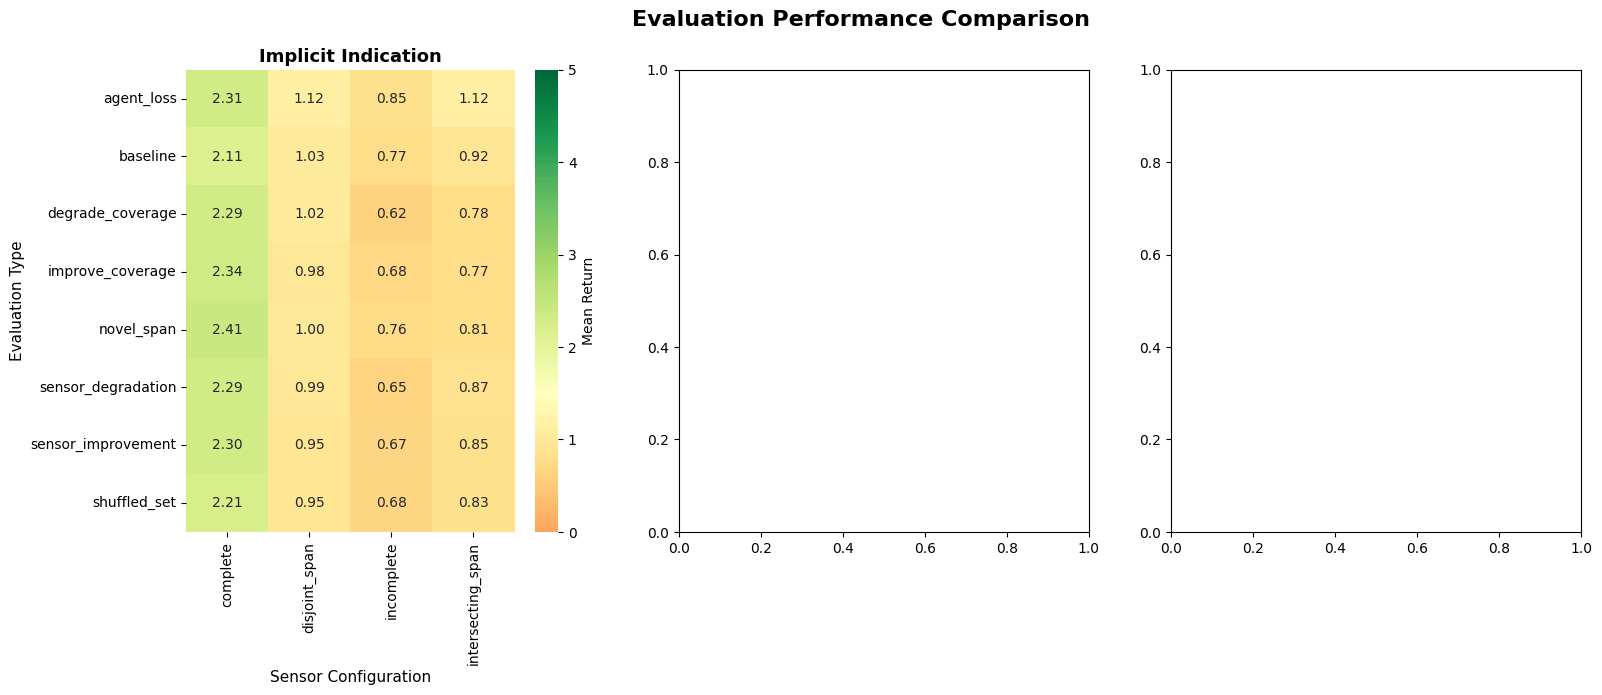

In [291]:
# !pip install seaborn
import seaborn as sns
# Create method labels
df_ev['method'] = df_ev['policy_type'].map({
    'default_het': 'Heterogeneous Baseline',
    'induced_hom': 'Implicit Indication',
    'PIC': 'PIC'
})

# Calculate mean performance for each condition
pivot_data = (
    df_ev
    # .groupby(['sensor_config', 'eval_type', 'method'])['metrics/returns/mean']
    .sort_values(['metrics/returns/mean'], ascending=False)
    .groupby(['sensor_config', 'eval_type', 'method'], group_keys=False)
    # .head(30)
    ['metrics/returns/mean'].mean().reset_index()
    )
# .sort_values(ascending=False)#[0:30].mean()


# Create separate pivots for each method
ii_pivot = pivot_data[pivot_data['method'] == 'Implicit Indication'].pivot(
    index='eval_type', columns='sensor_config', values='metrics/returns/mean'
)
pic_pivot = pivot_data[pivot_data['method'] == 'PIC'].pivot(
    index='eval_type', columns='sensor_config', values='metrics/returns/mean'
)

# Calculate difference (PIC - Implicit Indication)
diff_pivot = pic_pivot - ii_pivot

'''
print("\nImplicit Indication pivot:")
print(ii_pivot)
print("\nPIC pivot:")
print(pic_pivot)
print("\nDifference (PIC - II):")
print(diff_pivot)
'''

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Evaluation Performance Comparison', fontsize=16, fontweight='bold')

# Heatmap 1: Implicit Indication
sns.heatmap(ii_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=1.5, 
            ax=axes[0], cbar_kws={'label': 'Mean Return'}, vmin=0, vmax=5)
axes[0].set_title('Implicit Indication', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Sensor Configuration', fontsize=11)
axes[0].set_ylabel('Evaluation Type', fontsize=11)


In [357]:
summary

ii_pivot = summary[summary['policy_type'] == 'Implicit Ind.'].pivot(
    index='eval_type', columns='sensor_config', values='mean'
)
pic_pivot = summary[summary['policy_type'] == 'PIC'].pivot(
    index='eval_type', columns='sensor_config', values='mean'
)
# Calculate difference (PIC - Implicit Indication)
diff_pivot =  ii_pivot - pic_pivot

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Evaluation Performance Comparison', fontsize=16, fontweight='bold')

# Heatmap 1: Implicit Indication
sns.heatmap(ii_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=1.5, 
            ax=axes[0], cbar_kws={'label': 'Mean Return'}, vmin=0, vmax=10)
axes[0].set_title('Implicit Indication', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Sensor Configuration', fontsize=11)
axes[0].set_ylabel('Evaluation Type', fontsize=11)
# Heatmap 2: PIC
sns.heatmap(pic_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=1.5,
            ax=axes[1], cbar_kws={'label': 'Mean Return'}, vmin=0, vmax=10)
axes[1].set_title('PIC', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Sensor Configuration', fontsize=11)
axes[1].set_ylabel('')
# Heatmap 3: Difference (PIC - Implicit Indication) - negative means II is better
sns.heatmap(diff_pivot, annot=True, fmt='.2f', cmap='RdBu', center=2,
            ax=axes[2], cbar_kws={'label': 'Difference (PIC - II)'}, vmin=2, vmax=6)
axes[2].set_title('Difference (PIC - Impl. Indication)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Sensor Configuration', fontsize=11)
axes[2].set_ylabel('')

plt.tight_layout()
plt.savefig('eval_heatmaps_cleaned.png', dpi=150, bbox_inches='tight')
print("✓ Saved eval_heatmaps_cleaned.png")
plt.close()

✓ Saved eval_heatmaps_cleaned.png


In [280]:
df_ev[
    (df_ev["eval_type"]=="baseline") & (df_ev["policy_type"]=="induced_hom") & (df_ev["sensor_config"]=="complete")
    ]["metrics/returns/mean"].sort_values(ascending=False)#[0:30].mean()
# df_ev["metrics/returns/mean"]

46182    1.299375e+01
46189    1.253438e+01
46174    1.168125e+01
46187    1.113438e+01
46192    1.089375e+01
             ...     
49258    1.709743e-14
12093    1.709743e-14
12094    1.709743e-14
12095    1.709743e-14
46927    1.709743e-14
Name: metrics/returns/mean, Length: 900, dtype: float64